In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
#hep.CMS.text("Phase 2 Simulation")


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

# #line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5

2023-01-30 12:11:59.750135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Background rate plot (w.r.t pT)

In [2]:
def score_transform_old(iso, pt):
    
    PFTAU_NN_OFFSET = 0.1
    PFTAU_NN_SLOPE = 0.05
    PFTAU_NN_OVERALL_SCALE = 1. / 20.1

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 100.0
    
    return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))*PFTAU_NN_OVERALL_SCALE


def score_transform_new(iso, pt):
    
    PFTAU_NN_OFFSET = 0.36865313
    PFTAU_NN_SLOPE = 0.00137913
    PFTAU_NN_OVERALL_SCALE = 1./3.

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 200.0
    
    return iso*PFTAU_NN_OVERALL_SCALE*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))

# Plot it for old NN
PFTAU_NN_LOOSE_CUT = 0.05

MinBias = uproot4.open("../ntuples/Jan_25_2023/test_bkg_v11.root")
MinBias_id = np.asarray(MinBias['ntuplePupSingle']['tree']['event'].array())[400000:]
MinBias_iso = np.asarray(MinBias['ntuplePupSingle']['tree']['chargedIso'].array())[400000:]
MinBias_pt = np.asarray(MinBias['ntuplePupSingle']['tree']['pt'].array())[400000:]
MinBias_passloose = np.asarray(MinBias['ntuplePupSingle']['tree']['passLoose'].array() != 0.)[400000:]
MinBias_inputs = np.nan_to_num(np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array())[400000:])

n_event = np.unique(MinBias_id).shape[0]

MinBias_selected_pt = MinBias_pt[MinBias_passloose]
MinBias_selected_id = MinBias_id[MinBias_passloose]

In [4]:
model = load_model('../models/L1Tau_Jan_25_2023_NormalSample_v5.h5')
MinBias_nn_score_model = model.predict(MinBias_inputs)

7997/7997 [==============================] - 9s 1ms/step


In [5]:
MinBias_nn_score =  score_transform_new(MinBias_nn_score_model.flatten(), MinBias_pt)

In [6]:
MinBias_nn_selected_id = MinBias_id[MinBias_nn_score.flatten() > 0.05]
MinBias_nn_selected_pt = MinBias_pt[MinBias_nn_score.flatten() > 0.05]

In [7]:
minbias_rate = []
minbias_rate_nn = []
pt_cuts = list(np.arange(0,250,10))

for pt_cut in pt_cuts:
    
    print("pT Cut: ", pt_cut)
    n_pass = np.unique(MinBias_selected_id[MinBias_selected_pt > pt_cut]).shape[0]
    n_pass_nn = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt > pt_cut]).shape[0]
    print("Ratio: ", n_pass/n_event)
    print("Ratio (NN): ", n_pass_nn/n_event)
    
    minbias_rate.append((n_pass/n_event)*32e+3) #Convert to kHz
    minbias_rate_nn.append((n_pass_nn/n_event)*32e+3)

pT Cut:  0
Ratio:  0.1462904735717494
Ratio (NN):  0.20434824588285175
pT Cut:  10
Ratio:  0.1371641108093245
Ratio (NN):  0.18819869779313297
pT Cut:  20
Ratio:  0.03199684313486783
Ratio (NN):  0.02766454949603503
pT Cut:  30
Ratio:  0.010675409615844777
Ratio (NN):  0.011216946320698876
pT Cut:  40
Ratio:  0.004815058918353896
Ratio (NN):  0.005100520127114197
pT Cut:  50
Ratio:  0.002506181494557346
Ratio (NN):  0.0023592529312248386
pT Cut:  60
Ratio:  0.001591026442943441
Ratio (NN):  0.0012174080961836356
pT Cut:  70
Ratio:  0.0010410938201846263
Ratio (NN):  0.0006254958839012472
pT Cut:  80
Ratio:  0.0007934142419955418
Ratio (NN):  0.000369420387807448
pT Cut:  90
Ratio:  0.0005919122122823883
Ratio (NN):  0.00023928366028436973
pT Cut:  100
Ratio:  0.0004113999773310217
Ratio (NN):  0.00013013672752307828
pT Cut:  110
Ratio:  0.00032744079828387436
Ratio (NN):  9.2355096951862e-05
pT Cut:  120
Ratio:  0.00026027345504615656
Ratio (NN):  4.6177548475931e-05
pT Cut:  130
Ratio

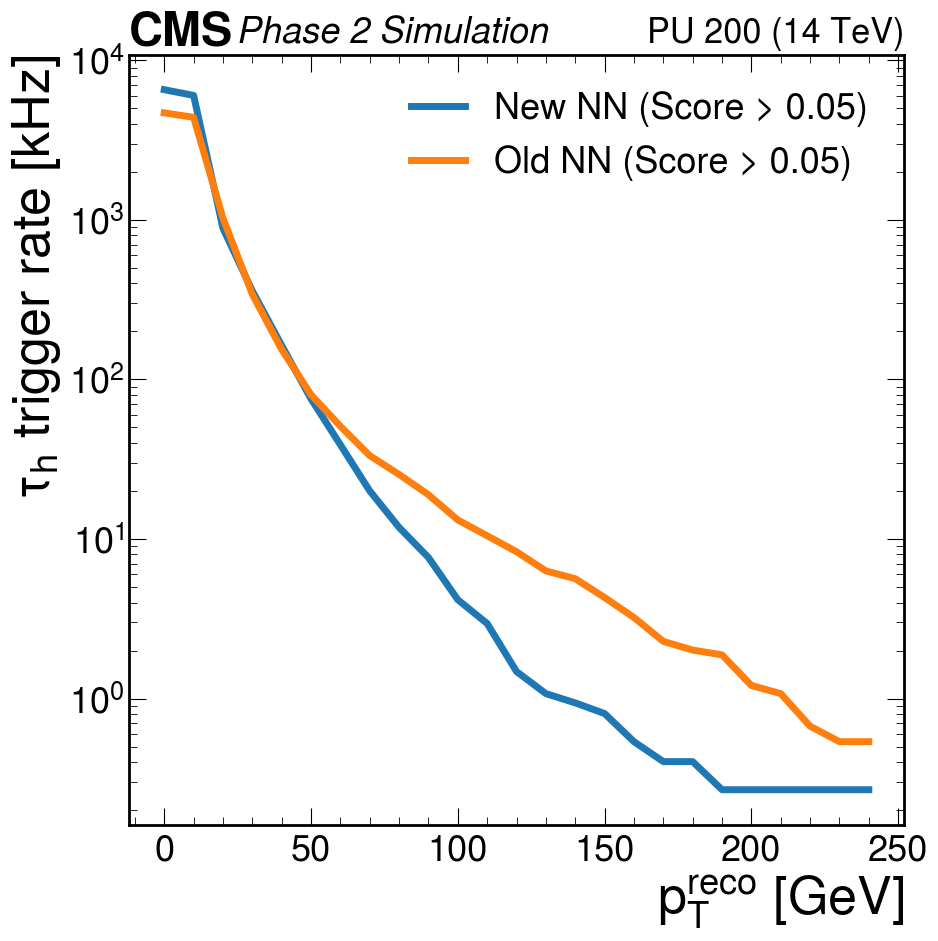

In [8]:
plt.plot(pt_cuts, minbias_rate_nn, label = "New NN (Score > 0.05)", linewidth=5)
plt.plot(pt_cuts, minbias_rate, label = "Old NN (Score > 0.05)", linewidth=5)
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.yscale('log')
plt.ylabel(r"$\tau_h$ trigger rate [kHz]")
plt.xlabel(r"$p_T^{reco}$ [GeV]")
plt.legend()
plt.show()

# ROC curve

In [2]:
def score_transform_old(iso, pt):
    
    PFTAU_NN_OFFSET = 0.1
    PFTAU_NN_SLOPE = 0.2
    PFTAU_NN_OVERALL_SCALE = 1. / 20.1

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 100.0
    
    return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))* PFTAU_NN_OVERALL_SCALE

def score_transform_new(iso, pt):
    
    PFTAU_NN_OFFSET = 0.36865313
    PFTAU_NN_SLOPE = 0.00137913
    PFTAU_NN_OVERALL_SCALE = 1./2.5

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 200.0
    
    return iso*PFTAU_NN_OVERALL_SCALE*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))

#Filter out the test signals
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
bkg = uproot4.open("../ntuples/Jan_25_2023/test_bkg_v11.root")

#Calculate the fake rate for old nn
unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array())[400000:])
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array())[400000:])

#Sig
truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[400000:]
truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:]
truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]

iso_sig = sig['ntuplePupSingle']['tree']['chargedIso'].array()[400000:]

selection_sig = (truth_pt_sig > 20) & (abs(truth_deltaR_sig) < 0.4) & (abs(truth_eta_sig) < 2.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[400000:][selection_sig])
reco_sig_pt_selected = np.asarray(reco_pt_sig[selection_sig])
sig_iso_selected = np.asarray(iso_sig[selection_sig])
y_sig = score_transform_old(sig_iso_selected, reco_sig_pt_selected)

#Bkg
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()[400000:])
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()[400000:]) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]
bkg_pt_selected = bkg_pt[selection_bkg]
bkg_iso_selected = np.asarray(bkg['ntuplePupSingle']['tree']['chargedIso'].array()[400000:])[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

y_bkg = score_transform_old(bkg_iso_selected, bkg_pt_selected)

In [3]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

In [4]:
sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])
    
    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

In [5]:
bkg_list_scaled = [i*(32e+3) for i in bkg_list]

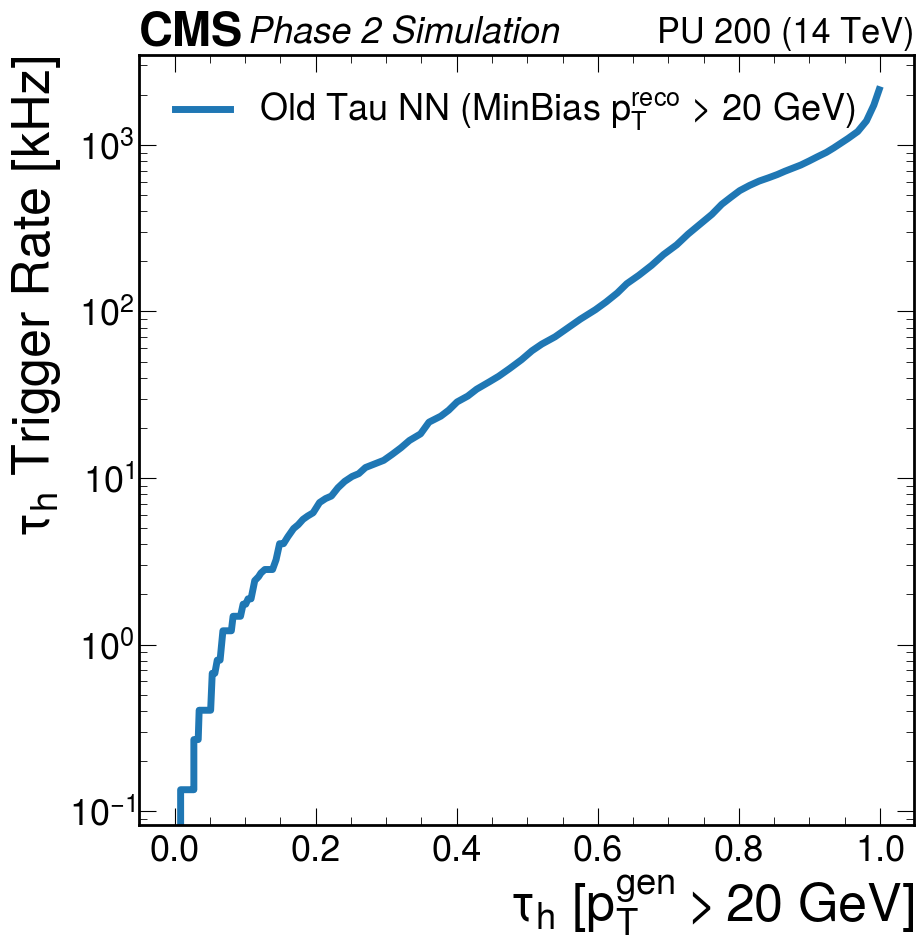

In [6]:
# sig_list_normal = np.load('sig_list_v3.npy')
# bkg_list_normal = np.load('bkg_list_v3.npy')
# bkg_list_normal_scaled = [i*(32e+3) for i in bkg_list_normal]

# plt.plot(sig_list_normal, bkg_list_normal_scaled, label='Retrained Tau NN',linewidth=5)
plt.plot(sig_list, bkg_list_scaled, label=r'Old Tau NN (MinBias $p_T^{reco}$ > 20 GeV)',linewidth=5)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > 20$ GeV]')
plt.yscale('log')
plt.legend()

In [7]:
np.save('Jan_25_2023_OldNN_x.npy', np.asarray(sig_list))
np.save('Jan_25_2023_OldNN_y.npy', np.asarray(bkg_list_scaled))

-----

In [3]:
def score_transform_old(iso, pt):
    
    PFTAU_NN_OFFSET = 0.1
    PFTAU_NN_SLOPE = 0.2
    PFTAU_NN_OVERALL_SCALE = 1. / 20.1

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 100.0
    
    return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))* PFTAU_NN_OVERALL_SCALE

def score_transform_new(iso, pt):
    
    PFTAU_NN_OFFSET = 0.36865313
    PFTAU_NN_SLOPE = 0.00137913
    PFTAU_NN_OVERALL_SCALE = 1./3.

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 200.0
    
    return iso*PFTAU_NN_OVERALL_SCALE*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))
#Filter out the test signals
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
bkg = uproot4.open("../ntuples/Jan_25_2023/test_bkg_v11.root")

unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array())[400000:])

#Load model and select out the tau
model = load_model('../models/L1Tau_Jan_25_2023_NormalSample_v5.h5')

#Sig
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[400000:]

truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[400000:]
truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:]
truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]
selection_sig = (truth_pt_sig > 20) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[400000:][selection_sig])

X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
X_sig[abs(X_sig) > 1e+4] = 0.
y_sig_model = model.predict(X_sig)
y_sig = score_transform_new(y_sig_model.flatten(), np.asarray(reco_pt_sig[selection_sig]).flatten())

#Bkg
bkg_input = np.asarray(bkg['ntuplePupSingle']['tree']['m_inputs'].array()[400000:])
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()[400000:])
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()[400000:]) 
selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

bkg_input[abs(bkg_input) > 1e+4] = 0.
y_bkg_model = model.predict(bkg_input[selection_bkg])
y_bkg = score_transform_new(y_bkg_model.flatten(), bkg_pt[selection_bkg].flatten())

573/573 [==============================] - 1s 1ms/step


In [4]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])
    
    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

bkg_list_scaled = [i*(32e+3) for i in bkg_list]

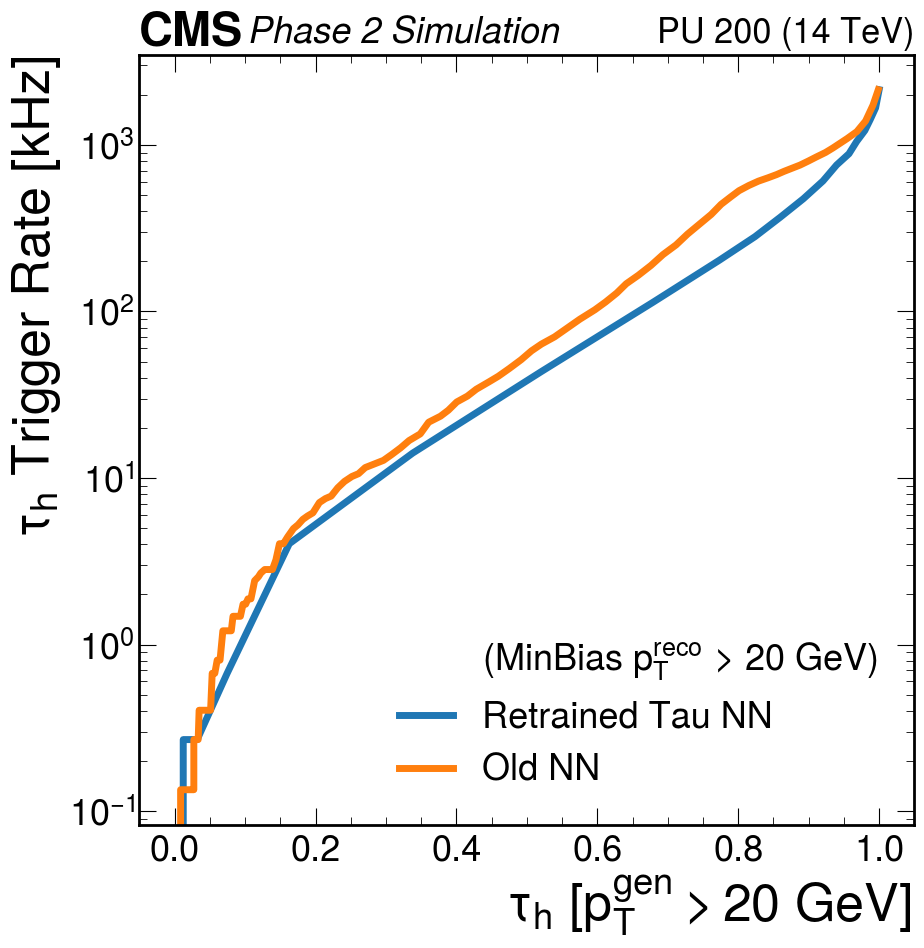

In [5]:
sig_list_old = np.load('Jan_25_2023_OldNN_x.npy')
bkg_list_old = np.load('Jan_25_2023_OldNN_y.npy')

plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco}$ > 20 GeV)')
plt.plot(sig_list, bkg_list_scaled, label=r'Retrained Tau NN',linewidth=5)
plt.plot(sig_list_old, bkg_list_old, label='Old NN',linewidth=5)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")

plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > 20$ GeV] ')

plt.yscale('log')
plt.legend()